<a href="https://colab.research.google.com/github/stiwari-ds/data-science-competitions/blob/main/dphi/ds78/notebooks/01_eda_and_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import gc
gc.enable()
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy.stats as st
import pandas as pd
pd.set_option('precision', 4)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

SEED = 23
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [2]:
train_url = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/ds78/data/train_dataset.csv'
test_url = 'https://raw.githubusercontent.com/stiwari-ds/data-science-competitions/main/dphi/ds78/data/test_dataset.csv'

In [3]:
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

# EDA

In [4]:
train.head()

,Tipster,Track,Horse,Bet Type,Odds,TipsterActive,Result
0,7,92,2279,0,26.0,True,0
1,7,114,11332,1,11.0,True,0
2,14,2,14120,0,41.0,True,0
3,8,12,328,1,4.5,True,1
4,16,24,15129,0,11.0,False,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10756 entries, 0 to 10755
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Tipster        10756 non-null  int64  
 1   Track          10756 non-null  int64  
 2   Horse          10756 non-null  int64  
 3   Bet Type       10756 non-null  int64  
 4   Odds           10756 non-null  float64
 5   TipsterActive  10756 non-null  bool   
 6   Result         10756 non-null  int64  
dtypes: bool(1), float64(1), int64(5)
memory usage: 514.8 KB


In [6]:
train.nunique()

Tipster            31
Track             104
Horse            7242
Bet Type            2
Odds              195
TipsterActive       2
Result              2
dtype: int64

In [7]:
TARGET = 'Result'
features = test.columns

### Result

In [8]:
train.Result.value_counts(normalize=True)

0    0.5
1    0.5
Name: Result, dtype: float64

Perfectly balanced.

### Tipster

In [9]:
pd.DataFrame(pd.crosstab(train['Tipster'], train[TARGET])).transpose()

Tipster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
Result,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,167,390,81,302,234,75,108,294,481,74,17,38,138,62,277,31,208,119,62,191,79,206,239,49,198,50,62,150,658,221,117
1,334,248,57,504,289,85,68,236,648,110,32,45,63,77,218,43,169,183,85,57,84,176,442,67,96,49,23,71,458,186,175


Some tipsters are very successful - 0, 3, 8, 22, etc.  
Others, not so much - 6, 12, 19, 24, 27, 28, etc.

### TipsterActive

In [10]:
pd.DataFrame(pd.crosstab(train['TipsterActive'], train[TARGET])).transpose()

TipsterActive,False,True
Result,,
0,1804,3574
1,1945,3433


Success rate is about the same for active and inactive tipsters.

In [11]:
pd.DataFrame(pd.crosstab(train['Tipster'], train['TipsterActive'])).transpose()

Tipster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
TipsterActive,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,0,0,806,523,160,0,0,0,184,49,0,201,0,0,0,377,0,147,0,0,382,0,0,0,0,0,221,0,407,292
True,501,638,138,0,0,0,176,530,1129,0,0,83,0,139,495,74,0,302,0,248,163,0,681,116,294,99,85,0,1116,0,0


No tipster has changed status within the dataset.

### Bet Type

In [12]:
pd.DataFrame(pd.crosstab(train['Bet Type'], train[TARGET])).transpose()

Bet Type,0,1
Result,,
0,1012,4366
1,1399,3979


Success rate is higher for Type-0 bets (assuming it to be a 'Win' bet judging from the [data description](https://dphi.tech/challenges/235/data)), but they are fewer in proportion.

### Odds

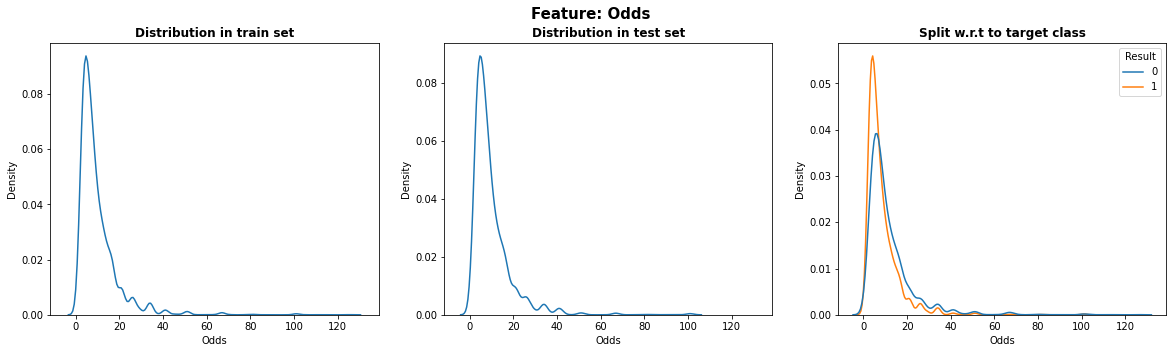

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
plt.suptitle(f'Feature: Odds', fontsize=15, fontweight='bold')
    
sns.kdeplot(x='Odds', data=train, ax=ax1)
ax1.set_title('Distribution in train set', fontweight='bold')
sns.kdeplot(x='Odds', data=test, ax=ax2)
ax2.set_title('Distribution in test set', fontweight='bold')
sns.kdeplot(x='Odds', data=train, hue=TARGET, ax=ax3)
ax3.set_title('Split w.r.t to target class', fontweight='bold')
    
plt.show()

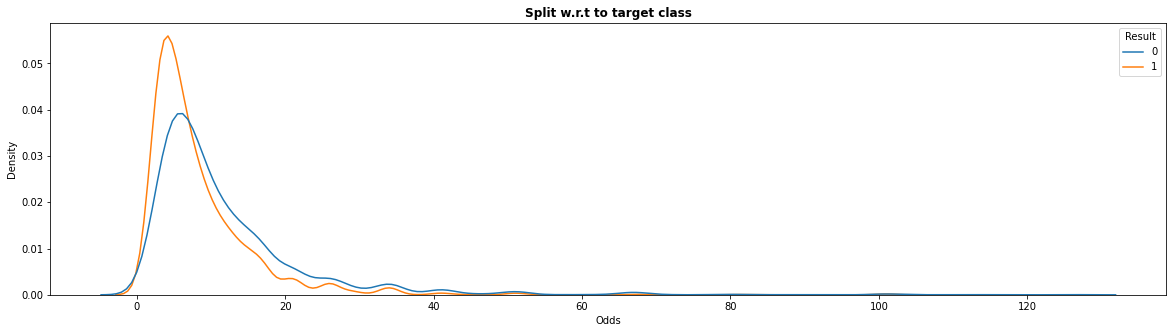

In [14]:
plt.figure(figsize=(20, 5))
ax = sns.kdeplot(x='Odds', data=train, hue=TARGET)
ax.set_title('Split w.r.t to target class', fontweight='bold')
plt.show()

Success rate seems to be higher for lower odds. 

### Horse

In [15]:
train.Horse.nunique(), test.Horse.nunique()

(7242, 3798)

In [16]:
print(f'% unique in train set: {train.Horse.nunique() / len(train) * 100:.2f}')
print(f'% unique in test set: {test.Horse.nunique() / len(test) * 100:.2f}')

% unique in train set: 67.33
% unique in test set: 82.39


In [17]:
len(set(train.Horse.unique()).intersection(set(test.Horse.unique())))

1878

Only 1878 horses are common. We will drop this columns as a feature.

### Track

In [18]:
train.Track.nunique(), test.Track.nunique()

(104, 101)

In [19]:
set(test.Track.unique()) - set(train.Track.unique())

{32, 58, 68}

3 unseen tracks in test set.

# Modeling

In [20]:
features = ['Tipster', 'Bet Type', 'Odds', 'TipsterActive']

y = train[TARGET]
X = train[features]
X_test = test[features]

cat_features = ['Tipster', 'Bet Type', 'TipsterActive']
X[cat_features] = X[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

In [21]:
def create_model():
    """Create preprocessing and modeling pipeline, return a Pipeline instance."""
    
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
    ])

    numerical_pipeline = Pipeline([
        ('standardize', RobustScaler()),
        ('normalize', MinMaxScaler())
    ])
    
    preprocessor = ColumnTransformer([
        ('cat_preprocessor', categorical_pipeline, make_column_selector(dtype_include='category')),
        ('num_preprocessor', numerical_pipeline, make_column_selector(dtype_include='number'))
    ])

    model = Pipeline([
        ('preprocessing', preprocessor),
        ('modeling', LogisticRegression(random_state=SEED, solver='liblinear'))
    ])
    
    return model

In [22]:
xtrain, xval, ytrain, yval = train_test_split(
    X, y, 
    test_size=0.2,
    stratify=y, 
    shuffle=True, 
    random_state=SEED)

In [23]:
model = create_model()
model.fit(xtrain, ytrain)

val_probs = model.predict_proba(xval)[:, 1] #probability of class = 1
val_preds = model.predict(xval)

print(f'AUC = {roc_auc_score(yval, val_probs):.4f}')
print('Classification report:')
print(classification_report(yval, val_preds, target_names=['class 0', 'class 1']))

AUC = 0.6662
Classification report:
              precision    recall  f1-score   support

     class 0       0.62      0.62      0.62      1076
     class 1       0.62      0.61      0.61      1076

    accuracy                           0.62      2152
   macro avg       0.62      0.62      0.62      2152
weighted avg       0.62      0.62      0.62      2152



In [24]:
predictions = model.predict(X_test)

In [25]:
submission = pd.DataFrame({'Result': predictions})
submission.to_csv('submission.csv', index=False)

In [26]:
!head submission.csv

Result
0
1
1
0
1
0
0
1
0
